## Assignment 3: CNN Cancer Detection Kaggle Mini-Project

### Description

 
This project is a binary image classification problem.  The goal of this project is to develop a convolutional nueral network model that can accurately identify metastatic cancer patches in an image.  The images are provided by the Kaggle Histopathologic Cancer Detection Competition and located at https://www.kaggle.com/competitions/histopathologic-cancer-detection/data.  Miltilayer convolutional nueral networks will be deleloped, traned and validated.  The best model will then be used to predict the labels on the test images.  


### Data Summary

The data consists of training and test images with image ids provided as the filename.  There are 220,025 training images and 57,458 test images. The train_labels.csv contains 220,025 rows that house the image id and assoiciated ground truth lables for the training images.  The sample_submission.csv contains the image ids of the test images and sampleground truth labels.  The labeles are to be replaced with test results and submitted for assessment of the model. 

In [1]:
#Set Page Width to 100%
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [19]:
#Load Required Resources
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import cv2
from sklearn import metrics
from sklearn.model_selection import train_test_split
import gc

import tensorflow as tf
from tensorflow.keras import models
from keras_preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.python.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Dropout, Activation, Flatten
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.optimizers import Adam

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  0
2.10.1


**GPU Limitation**
 :As noted above this project does not have GPU access.  Some models and simulations were reduced in complexity based on actual run times.

In [20]:
## Import Data
train_image_df = pd.read_csv('train/train_labels.csv')
test_image_df = pd.read_csv("sample_submission.csv" )

print(train_image_df.head(), '\n')
print(train_image_df.info(), '\n')
print(test_image_df.head(), '\n')
print(test_image_df.info())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None 

                                         id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to

### Data

See Images 1 and 2 for examples of negative and positive instances, respectively.  A review of the images, image ids and  and ground truth labels showed no anomolous cases.

The data consists of training and test images with image ids provided as the filename.  There are 220,025 training images and 57,458 test images. The train_labels.csv contains 220,025 rows that house the image id and assoiciated ground truth lables for the training images.  The sample_submission.csv contains the image ids of the test images and sampleground truth labels.  The labeles are to be replaced with test results and submitted for assessment of the model. 

Text(0.5, 1.0, 'Image 2: Positive')

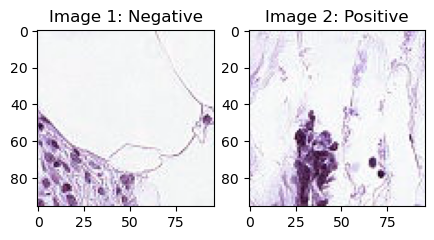

In [21]:
#Display Sample Images

fig, ax = plt.subplots(1, 2, figsize = (5, 5))

ax[0].imshow(cv2.imread('train/' + train_image_df['id'][0] + '.tif'))
ax[0].set_title('Image 1: Negative')
ax[1].imshow(cv2.imread('train/' + train_image_df['id'][1] + '.tif'))
ax[1].set_title('Image 2: Positive')

### EDA

As shown in plot 1, 59.5% of the training examples are negative while 40.5% positive.  This imbalance could result in biased trainig so the training set is rebalanced to a 50-50 split. Plot 2 shows the new distribution to be used as the training set.  As noted above, a review of the images, image ids and labels revealed no anomolies.  No addtional data cleansing or adjustments are required.


In [22]:
#Add tif file extension
train_image_df['id'] = train_image_df['id'].astype('str') + '.tif'
print(train_image_df.head())

test_image_df['id'] = test_image_df['id'].astype('str') + '.tif'
print(test_image_df.head())
print(test_image_df.info())

                                             id  label
0  f38a6374c348f90b587e046aac6079959adf3835.tif      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif      1
2  755db6279dae599ebb4d39a9123cce439965282d.tif      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif      0
4  068aba587a4950175d04c680d38943fd488d6a9d.tif      0
                                             id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif      0
1  95596b92e5066c5c52466c90b69ff089b39f2737.tif      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914.tif      0
3  2c35657e312966e9294eac6841726ff3a748febf.tif      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif      0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      57458 non-null  object
 1   label   57458 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 897.9+ KB
None


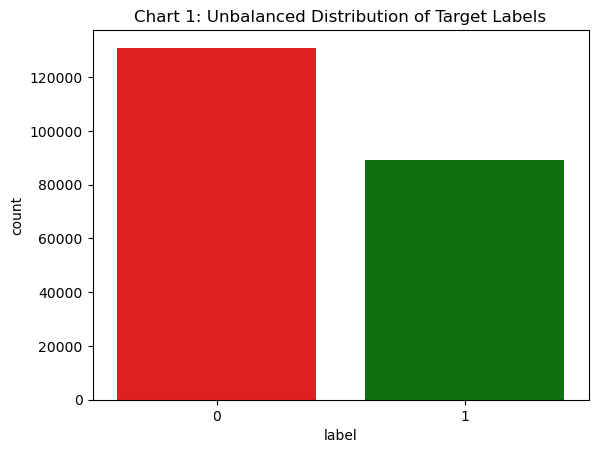

Negative Train Samples:  (89017, 2)
Positive Train Samples:  (89117, 2)
Train Image Id array shape:  (178134,)
Test Image Id array shape:  (57458,)


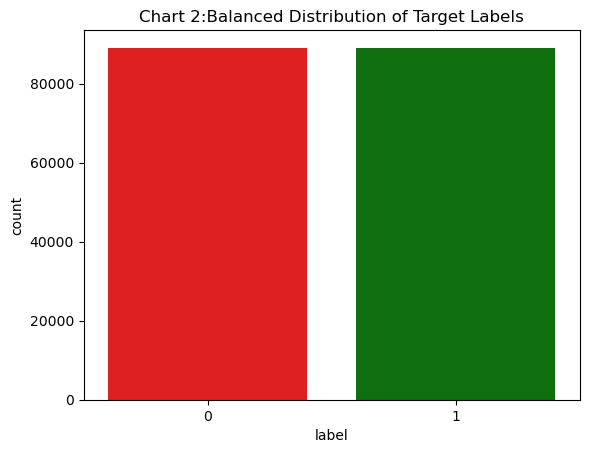

In [23]:
# Charts, data shape

plt.figure()
sns.countplot(data=train_image_df, x='label', palette=['#ff0000',"#008000"])
plt.title('Chart 1: Unbalanced Distribution of Target Labels')
plt.show()

# Rebalance and training arrays

#Remove 31% of negative images to balance dataset
train_image_df = train_image_df.drop(train_image_df[train_image_df['label'] == 0].sample(frac = .32).index)

train_negative_df = train_image_df[train_image_df['label'] == 0]
print('Negative Train Samples: ', train_negative_df.shape)

train_positive_df = train_image_df[train_image_df['label'] == 1]
print('Positive Train Samples: ', train_positive_df.shape)

#Convert to Numpy Array
train_image_id = train_image_df["id"].to_numpy()
test_image_id =  test_image_df["id"].to_numpy()
train_image_label = train_image_df["label"].to_numpy()

print('Train Image Id array shape: ', train_image_id.shape)
print('Test Image Id array shape: ', test_image_id.shape )

# Charts, new data shape
plt.figure()
sns.countplot(data=train_image_df, x='label', palette=['#ff0000',"#008000"])
plt.title('Chart 2:Balanced Distribution of Target Labels')
plt.show()


### Approach

Based on the EDA the following approach will be deployed.

1. Establish train and test sets.  25,000 images of each classification.
2. Preprocess the data (scaling, normalization).
3. Compare two models where the Batch Normalization layers are in different positions.  Before and after the Activation layer (optimizer - adam, metric - accuracy).
4. Improve best model through hyper-parameter tuning

***Model Architecture***

The core of the models will be the Convolutional layers.  The Convolutional model is extremely adapt at processing images to various levels.  Multiple Convolution layers (3) will be used in an effort to increase accuracy. The Convolutional layers are braketed by Batch Normalization and Max pooling layers.  These layers are added to improve both model performance and efficiency.  Relu activation will be used in the first three Activations layers as this method is best sited for this type of analysis.  A Dense layer is placed in front of the final Activation layer.  The final Activation layer will use sigmoid activation for classification purposes.

While designing the model, the question arose as where to place the Batch Normalization layers.  With that in mind, it was determined that two different models, with the Batch Normalization layers placed in differnt places would be a good basis for model comparison.  The first model has the Batch Normalization layers placed before the Activation layers.  The second model has the Batch Normalization layers placed after the Activation layers.  The models will be compared to determine the optimal location for the Batch Normalization layers. 

In [24]:
#### Pre-Process Data

#Set Training set size and split
negative_training_samples = train_negative_df.sample(n=25000, random_state=25)
positive_training_samples = train_positive_df.sample(n=25000, random_state=25)

full_train_set = pd.concat([negative_training_samples, positive_training_samples], axis=0).reset_index(drop=True)

full_train_set["label"].value_counts()

print(full_train_set.head())
print(full_train_set.info())

training_set, validation_set = train_test_split(full_train_set, random_state=25, test_size=0.3, shuffle=True, stratify=full_train_set["label"])


#Generate and scale images
data_image_generator = ImageDataGenerator(featurewise_center=False, zoom_range = 0.2, rotation_range = 30, rescale=1./255)

generator_train_set = data_image_generator.flow_from_dataframe(
                            dataframe=training_set,
                            directory='train/',
                            x_col="id",
                            y_col="label",                            
                            batch_size=32,                           
                            seed=25,
                            #class_mode="binary",
                            class_mode="raw",
                            target_size=(32,32))  

generator_validation_set = data_image_generator.flow_from_dataframe(
                            dataframe=validation_set,
                            directory='train/',
                            x_col="id",
                            y_col="label",
                            batch_size=32,
                            seed=25,
                            #class_mode="binary",
                            class_mode="raw",
                            target_size=(32,32))

generator_test_set = test_image_generator.flow_from_dataframe(
                            dataframe=test_image_df,
                            directory='test/',
                            x_col='id',
                            y_col= 'label',
                            batch_size=100,
                            #shuffle = False,
                            seed=25,
                            class_mode="raw",
                            target_size=(32,32), 
                            validation_steps=100)

                                             id  label
0  35a93e5612821c37670e70af150238932e20a942.tif      0
1  a3fa8742c25a40834271ecb40e23b28a323b27ff.tif      0
2  66bf34cfaa615793d2266e0668f0e81ba384f9a3.tif      0
3  a55f0f48559ed6328c6f666e6f32f8c4d13c52d9.tif      0
4  3e571e7b6cb092a08fb7d6592d54a7c5c47b8302.tif      0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      50000 non-null  object
 1   label   50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB
None
Found 35000 validated image filenames.
Found 15000 validated image filenames.
Found 57458 validated image filenames.


### Models

**Batch Normalization Before Activativation Layer**

In [54]:
#Before Model - two convolution layers, flatten layer, dense layer, batch normalization before Activation Layer
number_of_epochs = 20

before_model = Sequential()

before_model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))

before_model.add(BatchNormalization())
before_model.add(Activation('relu'))

before_model.add(MaxPooling2D(pool_size=(3, 3)))
before_model.add(Conv2D(64, (3, 3)))

before_model.add(BatchNormalization())
before_model.add(Activation('relu'))

before_model.add(MaxPooling2D(pool_size=(3, 3)))
before_model.add(Flatten())
before_model.add(Dense(128))

before_model.add(BatchNormalization())
before_model.add(Activation('relu'))

before_model.add(Dense(1))
before_model.add(Activation('sigmoid'))

before_model.summary()

before_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


before_history = before_model.fit(generator_train_set,
                    epochs = number_of_epochs, 
                    steps_per_epoch=(generator_train_set.n//generator_train_set.batch_size)//2,
                    validation_data = generator_validation_set,
                    validation_steps=(generator_validation_set.n//generator_validation_set.batch_size)//2)

before_model.save("before_model")

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
module_wrapper_47 (ModuleWra (None, 30, 30, 32)        128       
_________________________________________________________________
activation_61 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
module_wrapper_48 (ModuleWra (None, 8, 8, 64)          256       
_________________________________________________________________
activation_62 (Activation)   (None, 8, 8, 64)        

**Batch Normalization After Activativation Layer**

In [55]:
#Train models
#After Model - two convolution layers, flatten layer, dense layer, batch normalization after Activation Layer
after_model = Sequential()

after_model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))

after_model.add(Activation('relu'))
after_model.add(BatchNormalization())

after_model.add(MaxPooling2D(pool_size=(3, 3)))
after_model.add(Conv2D(64, (3, 3)))

after_model.add(Activation('relu'))
after_model.add(BatchNormalization())

after_model.add(MaxPooling2D(pool_size=(3, 3)))
after_model.add(Flatten())
after_model.add(Dense(128))

after_model.add(Activation('relu'))
after_model.add(BatchNormalization())

after_model.add(Dense(1))
after_model.add(Activation('sigmoid'))

after_model.summary()

after_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

after_history = after_model.fit(generator_train_set,
                    epochs = number_of_epochs, 
                    steps_per_epoch=(generator_train_set.n//generator_train_set.batch_size)//2,
                    validation_data = generator_validation_set,
                    validation_steps=(generator_validation_set.n//generator_validation_set.batch_size)//2)

after_model.save("after_model")

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
activation_65 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
module_wrapper_50 (ModuleWra (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
activation_66 (Activation)   (None, 8, 8, 64)          0         
_________________________________________________________________
module_wrapper_51 (ModuleWra (None, 8, 8, 64)        

### Model Comparison

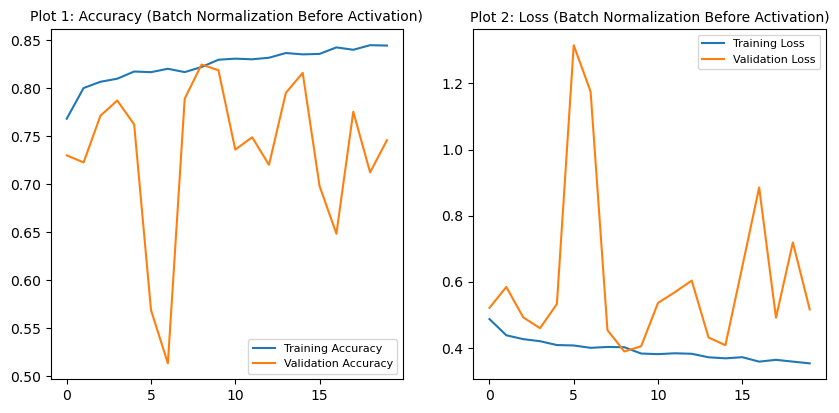

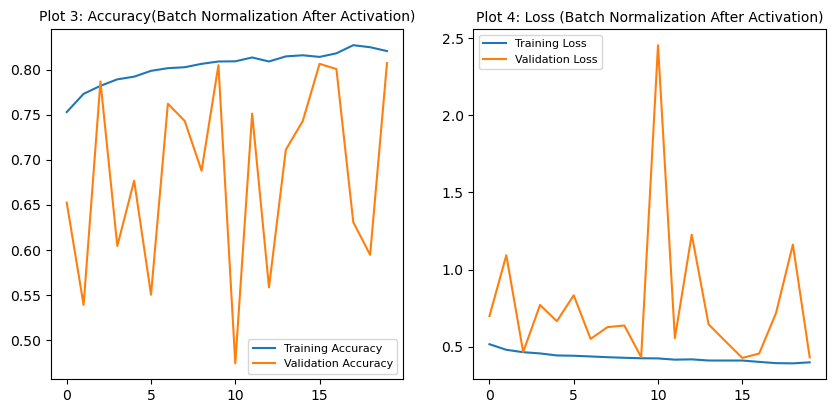

In [56]:
#Before Model
before_model_accuracy = before_history.history['accuracy']
before_model_val_acc = before_history.history['val_accuracy']
before_model_loss = before_history.history['loss']
before_model_val_loss = before_history.history['val_loss']

before_epochs_range = range(number_of_epochs)

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(before_epochs_range, before_model_accuracy, label='Training Accuracy')
plt.plot(before_epochs_range, before_model_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right', fontsize = 8)
plt.title('Plot 1: Accuracy (Batch Normalization Before Activation)', fontsize = 10)

plt.subplot(2, 2, 2)
plt.plot(before_epochs_range, before_model_loss, label='Training Loss')
plt.plot(before_epochs_range, before_model_val_loss, label='Validation Loss')
plt.legend(loc='upper right', fontsize = 8)
plt.title('Plot 2: Loss (Batch Normalization Before Activation)', fontsize = 10)
plt.show()

#After Model
after_model_accuracy = after_history.history['accuracy']
after_model_val_acc = after_history.history['val_accuracy']
after_model_loss = after_history.history['loss']
after_model_val_loss = after_history.history['val_loss']


after_epochs_range = range(number_of_epochs)

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(after_epochs_range, after_model_accuracy, label='Training Accuracy')
plt.plot(after_epochs_range, after_model_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right', fontsize = 8)
plt.title('Plot 3: Accuracy(Batch Normalization After Activation)', fontsize = 10)

plt.subplot(2, 2, 2)
plt.plot(after_epochs_range, after_model_loss, label='Training Loss')
plt.plot(after_epochs_range, after_model_val_loss, label='Validation Loss')
plt.legend(loc='upper left', fontsize = 8)
plt.title('Plot 4: Loss (Batch Normalization After Activation)', fontsize = 10)
plt.show()



**Table 1: Before and After Activation Layer vs Accuracy***

|Model|Accuracy|Validation Accuracy|
|:----|:--------:|:--------:|
|Before|.8293|.6723|
|After|.8020|.7432|


Plots 1 thru 4 provide a view of the training accuracy and loss metrics between the  models with the Batch Normalization layer berfore and after the activation layers.  Based on the charts and table, increasing the complexity by adding the additional dropout layers negatively impacted the accuracy.  

Table 1 indicates the more complex model showed ~1.5% degradation.  

However, when looking closely at the plots at around the 8th epoch, the before models traiing and accuracy begin to diverge, while the after modles accuracies trens are tracking.  Indicates that the before model is overfitting to the traiing data  resulting in a decrease in validation data accuracy.

The loss charges show a similiar pattern with the training and validation loss diverging while the aftermodels losses track and contue to show a converging pattern.  Again, another indication of overfitting of thebefore model.

model’s accuracy and los begin to show signs of slight cavitation.  Additionally, by the 15th epoch the loss and accuracy of the base model are essentially identical.  

Whereas the complex model’s accuracy and loss continue to converge with the gap between the two eventually leveling out around the 10th epoch.   
Taking these two observations together it appears that the simple model is showing signs of overfitting while the complex model does not.  The implication being that adding the additional dropout layers aided in protecting the complex model from overfitting. 



### Test Submission

In [53]:
# RANDOM_STATE = 42
# # set batch size
# BATCH_SIZE = 10
# # set input shape
# img_width, img_height = 64, 64
# input_shape = (img_width, img_height, 3)




# datagen = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset                           
#                              zoom_range = 0.2, # Randomly zoom image 
#                              rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
#                              width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#                              height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#                              horizontal_flip = True,  # randomly flip images
#                              rescale=1./255)    # multiply the data by the value provided
                            
    
                           
# train_generator = datagen.flow_from_dataframe(
#                             dataframe=training_set,
#                             directory='train/',
#                             x_col="id",
#                             y_col="label",                            
#                             batch_size=BATCH_SIZE,                           
#                             seed=RANDOM_STATE,
#                             class_mode="raw",
#                             target_size=(64,64))  


# validation_generator = datagen.flow_from_dataframe(
#                             dataframe=validation_set,
#                             directory='train/',
#                             x_col="id",
#                             y_col="label",
#                             batch_size=BATCH_SIZE,
#                             seed=RANDOM_STATE,
#                             class_mode="raw",
#                             target_size=(64,64))



# new_model = Sequential()
# # first convolutional layer
# new_model.add(Conv2D(32, (3, 3), input_shape=input_shape))
# new_model.add(BatchNormalization())
# new_model.add(Activation('relu'))
# new_model.add(MaxPooling2D(pool_size=(2, 2)))

# # second convolutional layer

# new_model.add(Conv2D(64, (3, 3)))
# new_model.add(BatchNormalization())
# new_model.add(Activation('relu'))
# new_model.add(MaxPooling2D(pool_size=(2, 2)))
  
# # third convolutional layer
# new_model.add(Conv2D(128, (3, 3)))
# new_model.add(BatchNormalization())
# new_model.add(Activation('relu'))
# new_model.add(MaxPooling2D(pool_size=(2, 2)))

# new_model.add(Flatten())
# new_model.add(Dense(256))
# new_model.add(BatchNormalization())
# new_model.add(Activation('relu'))
# new_model.add(Dropout(0.4))

# # Out layer
# new_model.add(Dense(1))
# new_model.add(Activation('sigmoid'))

# new_model.summary()

# # compile new model
# new_model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])
# # let’s train our model for 20 epochs
# STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
# STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
# new_history = new_model.fit(train_generator,
#                     epochs = 2 , 
#                     steps_per_epoch=STEP_SIZE_TRAIN,
#                     validation_data = validation_generator,
#                     validation_steps=STEP_SIZE_VALID)
#                     #callbacks=callback)


# test_datagen = ImageDataGenerator(rescale=1./255)
# test_generator = test_datagen.flow_from_dataframe(
#                             dataframe=test_image_df,
#                             directory='test/',
#                             x_col="id",
#                             y_col=None,
#                             batch_size=BATCH_SIZE,
#                             shuffle=False,
#                             seed=RANDOM_STATE,
#                             class_mode=None,
#                             target_size=(64,64))

# t_predictions = new_model.predict(test_generator, verbose=1)
# t_predictions
#5746/5746 [==============================] - 108s 19ms/step


# #test case use before_model
# # 10% of test images
# #test_samples = test_image_df.sample(n=5000, random_state=25)
print(test_image_df)

print(test_image_df.head())
print(test_image_df.info())

# test_image_generator = ImageDataGenerator(featurewise_center=False, zoom_range = 0.2, rotation_range = 30, rescale=1./255)
# print(test_image_generator)


# print(generator_test_set)

test_results = before_model.predict(generator_test_set,  batch_size = (generator_test_set.n//generator_test_set.batch_size), verbose=1)
print(test_results)
test_results

#3500/3500 [==============================] - 108s 19ms/step



                                                 id  label
0      0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif      0
1      95596b92e5066c5c52466c90b69ff089b39f2737.tif      0
2      248e6738860e2ebcf6258cdc1f32f299e0c76914.tif      0
3      2c35657e312966e9294eac6841726ff3a748febf.tif      0
4      145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif      0
...                                             ...    ...
57453  061847314ded6f81e1cd670748bfa2003442c9c7.tif      0
57454  6f3977130212641fd5808210015a609c658dcbff.tif      0
57455  46935f247278539eca74b54d07d666efb528a753.tif      0
57456  a09bcae08a82120183352e0e869181b2911d3dc1.tif      0
57457  d29233dc0b90c2e1a8fcedbc3e1234c3d4dbd55b.tif      0

[57458 rows x 2 columns]
                                             id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif      0
1  95596b92e5066c5c52466c90b69ff089b39f2737.tif      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914.tif      0
3  2c35657e312966e9294eac6841726ff3a748febf.ti

KeyboardInterrupt: 

In [ ]:
#Generate submission file
test_submission = np.where(test_results <= 0.5, 0, 1)

final_submission = np.transpose(test_submission)[0]
final_final_submission = pd.DataFrame()
final_submission['id'] = test_image_df['id'].apply(lambda x: x.split('.')[0])
final_submission['label'] = test_submission
final_submission.head()

final_submission.to_csv('submission.csv', index=False)

In [ ]:
Submission Screen shot

In [ ]:
Leaderboard Screen shot

### Hyperparameter Tuning

Momentum on the Batch Normalization Layers will be varied and the impact on accruacy assessed.

In [39]:
mv2 = [.99, .75, .50, .25]
history = []

for m in mv2:
    before_model = Sequential()

    before_model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
    before_model.add(BatchNormalization(momentum = m))
    before_model.add(Activation('relu'))
    before_model.add(MaxPooling2D(pool_size=(3, 3)))

    before_model.add(Conv2D(64, (3, 3)))
    before_model.add(BatchNormalization(momentum = m))
    before_model.add(Activation('relu'))
    before_model.add(MaxPooling2D(pool_size=(3, 3)))
  
    before_model.add(Flatten())
    before_model.add(Dense(128))
    before_model.add(BatchNormalization(momentum = m))
    before_model.add(Activation('relu'))


    before_model.add(Dense(1))
    before_model.add(Activation('sigmoid'))

    before_model.summary()

    before_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    number_of_epochs = 20
    
    
    tune_history = before_model.fit(generator_train_set,
                    epochs = number_of_epochs, 
                    steps_per_epoch=(generator_train_set.n//generator_train_set.batch_size)//2,
                    validation_data = generator_validation_set,
                    validation_steps=(generator_validation_set.n//generator_validation_set.batch_size)//2)
    
    
    
    
    print('Momentum: ', m)
    print('History: ', tune_history.history)
    history.append(tune_history.history)
    
    

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
module_wrapper_15 (ModuleWra (None, 30, 30, 32)        128       
_________________________________________________________________
activation_20 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
module_wrapper_16 (ModuleWra (None, 8, 8, 64)          256       
_________________________________________________________________
activation_21 (Activation)   (None, 8, 8, 64)         

Epoch 1/20
546/546 [==============================] - 116s 211ms/step - loss: 0.4919 - accuracy: 0.7659 - val_loss: 0.5644 - val_accuracy: 0.7285
Epoch 2/20
546/546 [==============================] - 107s 197ms/step - loss: 0.4530 - accuracy: 0.7923 - val_loss: 0.5167 - val_accuracy: 0.7654
Epoch 3/20
546/546 [==============================] - 96s 176ms/step - loss: 0.4406 - accuracy: 0.7970 - val_loss: 0.5783 - val_accuracy: 0.7190
Epoch 4/20
546/546 [==============================] - 106s 195ms/step - loss: 0.4201 - accuracy: 0.8094 - val_loss: 0.4414 - val_accuracy: 0.7971
Epoch 5/20
546/546 [==============================] - 95s 174ms/step - loss: 0.4116 - accuracy: 0.8178 - val_loss: 0.3914 - val_accuracy: 0.8268
Epoch 6/20
546/546 [==============================] - 105s 193ms/step - loss: 0.4132 - accuracy: 0.8136 - val_loss: 0.6397 - val_accuracy: 0.6877
Epoch 7/20
546/546 [==============================] - 92s 168ms/step - loss: 0.4006 - accuracy: 0.8197 - val_loss: 0.5008 - va

546/546 [==============================] - 82s 150ms/step - loss: 0.3910 - accuracy: 0.8277 - val_loss: 0.3852 - val_accuracy: 0.8333
Epoch 11/20
546/546 [==============================] - 75s 137ms/step - loss: 0.3797 - accuracy: 0.8310 - val_loss: 0.3611 - val_accuracy: 0.8451
Epoch 12/20
546/546 [==============================] - 78s 143ms/step - loss: 0.3891 - accuracy: 0.8263 - val_loss: 0.3924 - val_accuracy: 0.8223
Epoch 13/20
546/546 [==============================] - 81s 148ms/step - loss: 0.3823 - accuracy: 0.8278 - val_loss: 0.4996 - val_accuracy: 0.7730
Epoch 14/20
546/546 [==============================] - 86s 158ms/step - loss: 0.3770 - accuracy: 0.8325 - val_loss: 0.3968 - val_accuracy: 0.8247
Epoch 15/20
546/546 [==============================] - 87s 159ms/step - loss: 0.3695 - accuracy: 0.8376 - val_loss: 0.3887 - val_accuracy: 0.8360
Epoch 16/20
546/546 [==============================] - 85s 156ms/step - loss: 0.3650 - accuracy: 0.8393 - val_loss: 0.3647 - val_accurac

546/546 [==============================] - 107s 196ms/step - loss: 0.3625 - accuracy: 0.8414 - val_loss: 0.3528 - val_accuracy: 0.8471
Epoch 20/20
546/546 [==============================] - 140s 256ms/step - loss: 0.3511 - accuracy: 0.8432 - val_loss: 0.3590 - val_accuracy: 0.8436
Momentum:  0.25
History:  {'loss': [0.49455761909484863, 0.45400887727737427, 0.4431801736354828, 0.42225244641304016, 0.41612425446510315, 0.4103754758834839, 0.39658114314079285, 0.40131276845932007, 0.392747163772583, 0.39335402846336365, 0.38575831055641174, 0.387124240398407, 0.3826524615287781, 0.3773442804813385, 0.3748388886451721, 0.3683342933654785, 0.3604435622692108, 0.36442652344703674, 0.3624778091907501, 0.3511473834514618], 'accuracy': [0.765632152557373, 0.7895489931106567, 0.7976981401443481, 0.808779776096344, 0.8120132684707642, 0.8149038553237915, 0.823007345199585, 0.8206272721290588, 0.8220338821411133, 0.8242330551147461, 0.8299358487129211, 0.8282967209815979, 0.8299931287765503, 0.83

### Hyperparameter Tuning Results

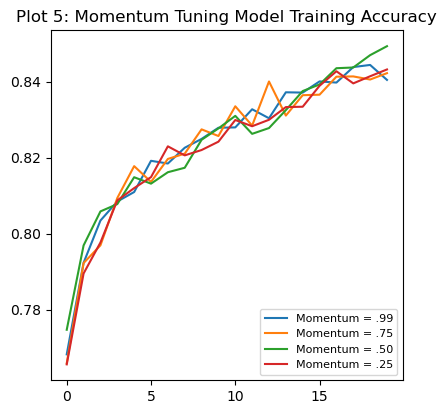

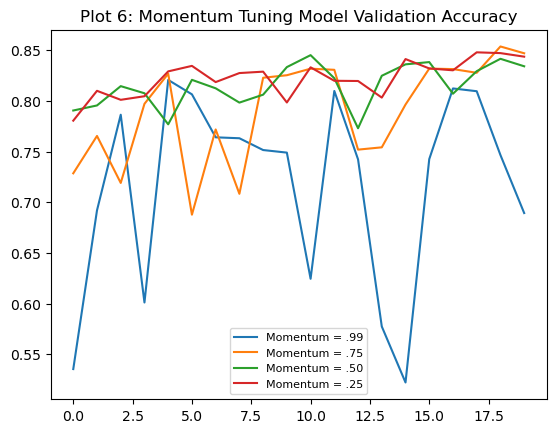

In [44]:
tune_epochs_range = range(number_of_epochs)

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(tune_epochs_range, history[0]['accuracy'], label='Momentum = .99')
plt.plot(tune_epochs_range, history[1]['accuracy'], label='Momentum = .75')
plt.plot(tune_epochs_range, history[2]['accuracy'], label='Momentum = .50')
plt.plot(tune_epochs_range, history[3]['accuracy'], label='Momentum = .25')
plt.legend(loc='lower right', fontsize=8)
plt.title('Plot 5: Momentum Tuning Model Training Accuracy')
plt.show()
#plt.subplot(2, 2, 2)
plt.plot(tune_epochs_range, history[0]['val_accuracy'], label='Momentum = .99')
plt.plot(tune_epochs_range, history[1]['val_accuracy'], label='Momentum = .75')
plt.plot(tune_epochs_range, history[2]['val_accuracy'], label='Momentum = .50')
plt.plot(tune_epochs_range, history[3]['val_accuracy'], label='Momentum = .25')
plt.legend(loc='lower center', fontsize=8)
plt.title('Plot 6: Momentum Tuning Model Validation Accuracy')
plt.show()

#### Accuracy Comparison / Analysis
**Table 2: Momentum vs Accuracy**

|Momentum|Accuracy|Validation Accuracy|
|:----|:--------:|:--------:|
|.99|.8409|.7505|
|.75|.8375|.8374|
|.50|.8431|.8449|
|.25|.8379|.8389|

As can be seen in Plot 5 and table 2, 'Momentum vs Accuracy’, all 4 momentum levels reach similar levels of accuracy.  Model 3, momentum = .5, performed best with an accuracy of 84.31%.  The worst performer was Model 2, momentum = .73, with accuracy of 83.75%.  When comparing models strictly from an accuracy there is no appreciable difference between models.  The best and worst performers were separated by only .56%, essentially no difference.

However, it’s how the models got there that is interesting.  Plot 5 shows that Model 4, momentum = .25 exhibited the least amount of variability through its trajectory.  On the other hand, Model 1, momentum = .99 varied wildly throughout its path.  This is not unexpected as the larger momentum would be expected to ‘bounce’ around more than the lower momentum values.

Plot 6, validation accuracy more clearly details how the higher momentums impact the loss trajectory.  As expected, as the momentum of the models degreased, so did the variation in the loss path.

Given the marginal difference in accuracy in conjunction with the variation in the accuracy trajectories, the data shows that working with the lower momentum provides a much more stable model in terms of accuracy and loss.  Model 4, momentum = .25 is the preferred model.  

In [ ]:




started at 50,00 images, moved to 25,000 too long
started at 20 epochs, too long

Initally started with step sizes defaulted to none and the 1 epoch took over 2 hours with accuraccy of 74%
CHanged to step size of XXX, epoch dropped to 3 mins with increased accuraccy 74%

stpe size half better accurracy 80%

### Conclusion

**Model Comparison**

Over 15 epochs, comparisons of the simple and complex models showed marginal accuracy and loss differences.  The simple model performed slightly better with its final accuracy 1.2% better at 98.42%, then the complex model at 97.22%.

However as outlined above, the simple model began to show signs of overfitting at around the 10th epoch, while the complex model did not.  Based on the analysis and discussion above, the conclusion is that the addition of the drop out layers to the complex model proved to be beneficial.  Given the marginal difference in performance and the overfitting protection on the complex model, the complex model is deemed the better of the two.


**Hyper paramter Tuning**

Hyper parameter tuning, varying the number of epochs, provided some insight into how epoch count impacted the model’s performance.  The total difference in performance across the 4 different epoch counts resulted in a maximum accuracy difference of 1.01% between 5 and 20 epochs.  The middle two epoch counts (10 and15) resulted in only a .36% difference in accuracy.
When considering the essentially identical accuracy rate climb between models and the minimal accuracy differences, 10 epochs is deemed more than sufficient in getting good accuracy, while balancing computation effort.


**Test Submission**

Best model submission was 78.85%. Based on the much better performance of the training and validation models one can conclude that overfitting existed or that the test data was reasonably different from the training data set.  Most likely a combination of both.